In [76]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.python.keras.models import Model
import tensorflow as tf
import pathlib
from tensorflow.python.keras import layers
import os

Shape of the image (1890,)


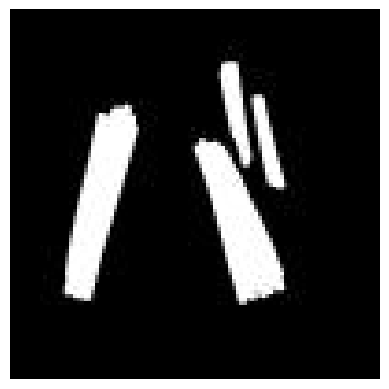

Shape of the image (2268,)


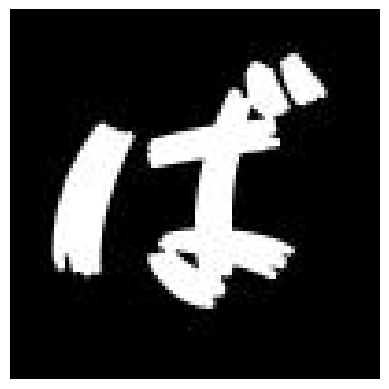

In [77]:
url_kata = r'https://github.com/Orzelius/7500-unique-kana-images/blob/master/katakana/ba_851CHIKARA-DZUYOKU-KANA-A_dakutrue.jpeg?raw=true'
resp = requests.get(url_kata, stream=True).raw
image_array_baKata = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_baKata.shape}')
image_baKata = cv2.imdecode(image_array_baKata, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_baKata, cv2.COLOR_BGR2RGB))
plt.show()

url_hira = r'https://github.com/Orzelius/7500-unique-kana-images/blob/master/hiragana/ba_851CHIKARA-DZUYOKU-KANA-A_dakutrue.jpeg?raw=true'
resp = requests.get(url_hira, stream=True).raw
image_array_baHira = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_baHira.shape}')
image_baHira = cv2.imdecode(image_array_baHira, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_baHira, cv2.COLOR_BGR2RGB))
plt.show()

(40, 40, 3)
(40, 40)


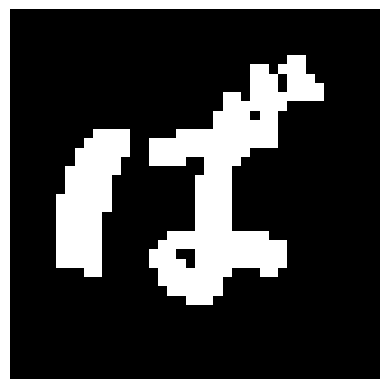

In [78]:
res = cv2.resize(image_baHira , dsize=(40,40), interpolation=cv2.INTER_CUBIC)
print(res.shape)
res = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY) #TO 3D to 1D
print(res.shape)
res = cv2.threshold(res, 127, 255, cv2.THRESH_BINARY)[1]
d = res

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [79]:
dataDir = pathlib.Path("dataset/kanaSeparated/")
validDir = pathlib.Path("dataset/kanaValidationSeparated/")
print(dataDir)

dataset/kanaSeparated


In [80]:
batchSize = 32
imgHeight = 100
imgWidth = 100

In [81]:
trainData = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize,
)

validationData = tf.keras.preprocessing.image_dataset_from_directory(
    validDir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize,
)

classNames = validationData.class_names
print(len(classNames))

Found 3628 files belonging to 67 classes.
Using 2903 files for training.
Found 928 files belonging to 67 classes.
Using 185 files for validation.
67


2023-07-12 17:32:36.207320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2903]
	 [[{{node Placeholder/_0}}]]
2023-07-12 17:32:36.207724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2903]
	 [[{{node Placeholder/_4}}]]


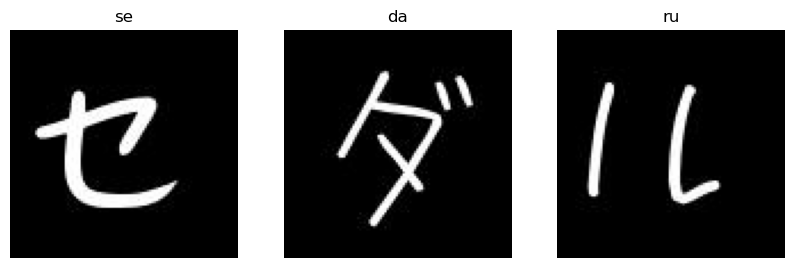

In [82]:
plt.figure(figsize=(10, 10))
for images, labels in trainData.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

In [83]:
numClass = len(classNames)
print(classNames)
print(numClass)

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(numClass, activation='softmax')
])

['ba', 'be', 'bi', 'bo', 'bu', 'da', 'de', 'di', 'do', 'du', 'ga', 'ge', 'gi', 'go', 'gu', 'ha', 'he', 'hi', 'ho', 'hu', 'ka', 'ke', 'ki', 'ko', 'ku', 'ma', 'me', 'mi', 'mo', 'mu', 'na', 'ne', 'ni', 'no', 'nu', 'pa', 'pe', 'pi', 'po', 'pu', 'ra', 're', 'ri', 'ro', 'ru', 'sa', 'se', 'si', 'so', 'su', 'ta', 'te', 'ti', 'to', 'tu', 'wa', 'wo', 'wu', 'ya', 'yi', 'yo', 'yu', 'za', 'ze', 'zi', 'zo', 'zu']
67


In [84]:
model.compile(optimizer='adam',
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
            )

In [85]:
logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                    embeddings_data=trainData
                                                    )

In [87]:
model.fit( 
    trainData,
    validation_data=validationData,
    epochs=20,
    callbacks=[tensorboard_callback],
    verbose=1
    )

Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/20


91/91 [==============================] - ETA: 0s - loss: 3.8403 - accuracy: 0.0923

2023-07-12 17:33:53.164879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [185]
	 [[{{node Placeholder/_4}}]]
2023-07-12 17:33:53.165576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [185]
	 [[{{node Placeholder/_0}}]]
/Users/nabyl/anaconda3/envs/test/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(

91/91 [==============================] - 56s 618ms/step - loss: 3.8403 - accuracy: 0.0923 - val_loss: 3.1269 - val_accuracy: 0.2432
Epoch 2/20
91/91 [==============================] - 58s 636ms/step - loss: 2.2857 - accuracy: 0.3789 - val_loss: 2.0506 - val_accuracy: 0.4486
Epoch 3/20
91/91 [==============================] - 58s 636ms/step - loss: 1.3991 - accuracy: 0.5804 - val_loss: 1.5650 - val_accuracy: 0.5838
Epoch 4/20
91/91 [==============================] - 55s 607ms/step - loss: 0.9531 - accuracy: 0.7096 - val_loss: 1.4012 - val_accuracy: 0.6216
Epoch 5/20
91/91 [==============================] - 56s 617ms/step - loss: 0.6685 - accuracy: 0.7771 - val_loss: 1.3038 - val_accuracy: 0.6486
Epoch 6/20
91/91 [==============================] - 55s 603ms/step - loss: 0.4799 - accuracy: 0.8450 - val_loss: 1.3339 - val_accuracy: 0.6811
Epoch 7/20
91/91 [==============================] - 56s 615ms/step - loss: 0.3386 - accuracy: 0.8846 - val_loss: 1.4449 - val_accuracy: 0.6811
Epoch 8/20

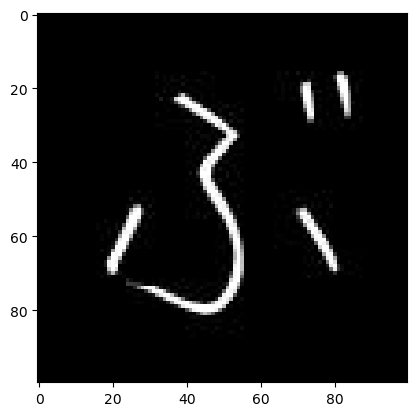

1/1 [==============================] - 0s 218ms/step
bu


In [91]:
image = cv2.imread("dataset/kanaSeparated/bu/bu_DartsFont_dakutrue.jpeg",cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

image = np.expand_dims(cv2.resize(image,(100,100)), axis=0)

prediction = model.predict(image) 
classes = np.argmax(prediction,axis=1)

print(classNames[int(classes)])

In [92]:
# Save the model to SaveModel format
tf.saved_model.save(model, 'weights_JS_format/saved_model/')

# Save the weights
#model.save_weights('weights/katakanaWeights')

INFO:tensorflow:Assets written to: weights_JS_format/saved_model/assets


INFO:tensorflow:Assets written to: weights_JS_format/saved_model/assets


In [30]:
# Create a new model instance
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(numClass, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
            )

# Restore the weights
model.load_weights('weights/katakanaWeights')

# Evaluate the model
loss, acc = model.evaluate(validationData, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

/Users/nabyl/anaconda3/envs/test/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3/3 [==============================] - 1s 121ms/step - loss: 0.6567 - accuracy: 0.8400
Restored model, accuracy: 84.00%


INFO:tensorflow:Assets written to: weights_JS_format/saved_model/assets


INFO:tensorflow:Assets written to: weights_JS_format/saved_model/assets


In [93]:
from tensorflowjs.converters.converter import tf_saved_model_conversion_v2 as convert

# Convert the weights to JSON format
convert.convert_tf_saved_model('weights_JS_format/saved_model/', 'weights_JS_format/')

2023-07-12 18:09:33.085554: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
